# Modeling Support for Defuning the Police with Pew Data

In this notebook, I threw a ton of models at the wall to see what would stick. In the end, I discovered that I couldn't manage to get my R<sup>2</sup> score above .23  or so. My best model was the VotingRegressor that ensembled linear regression, lasso, random forest, and gradient boost models for a score of .2376. But even with that best score, the RMSE was .2396; in other words, when trying to predict a value between 0 and 1, my model's predictions are off by an average of .24 or 24%. So the model itself might not be that helpful, but perhaps there is something to learn from the features and their relative importances. The top ten most important features were `political_party_gop, political_party_dem, age_group_18_29, education_level, religion_protestant, income_bracket, relig_activity, religion_atheist, religion_catholic,` and `religion_agnostic'.

## Imports and prep

After importing the various libraries and packages I'm going to use in this section, I split the dataset into training and testing sets, scaled my features, and used MinMaxScaler to put the target variable (police favorability) on a scale of 0 to 1. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
df = pd.read_csv('../data/pew_cleaned.csv')
df.head()

,defund_support,lives_in_metro_area,is_female,education_level,is_hispanic,is_citizen,relig_activity,income_bracket,internet_access,social_media_user,...,religion_none,religion_orthodox,religion_other,religion_protestant,political_party_dem,political_party_gop,political_party_ind,voter_status_not_registered,voter_status_prob_registered,voter_status_registered
0,3.0,1,0.0,5.0,0.0,1.0,5.0,6.0,1,0.0,...,1,0,0,0,0,1,0,0,0,1
1,1.0,1,1.0,4.0,0.0,1.0,3.0,4.0,1,1.0,...,0,0,0,1,0,0,1,0,0,1
2,2.0,1,0.0,6.0,0.0,1.0,5.0,7.0,0,1.0,...,0,0,0,0,0,0,1,1,0,0
3,5.0,1,0.0,3.0,1.0,1.0,6.0,6.0,1,1.0,...,0,0,0,0,0,1,0,0,0,1
4,3.0,1,0.0,5.0,0.0,1.0,5.0,9.0,1,0.0,...,0,0,0,0,0,0,1,0,0,1


In [3]:
X = df.drop(columns = 'defund_support')
y = df['defund_support']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42, stratify = y)

sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

mm = MinMaxScaler()

y_train = mm.fit_transform(np.array(y_train).reshape(-1, 1))[:,0]
y_test = mm.transform(np.array(y_test).reshape(-1, 1))[:,0]

## Throwing models at the wall and seeing what sticks

In this section, I created a for loop to see which models seemed to be the best fit for this project. I mostly focused on the testing scores when evaluating these, but was also interested in the range of predictions and the pattern of residuals. I moved forward with the four models from the loop with the highest testing scores to experiment further.

KNeighborsRegressor() 

Training score: 0.3983 , Testing score: 0.0866 

Baseline: 2.9587 , Pred mean: 0.4592 , Pred variance: 0.0127


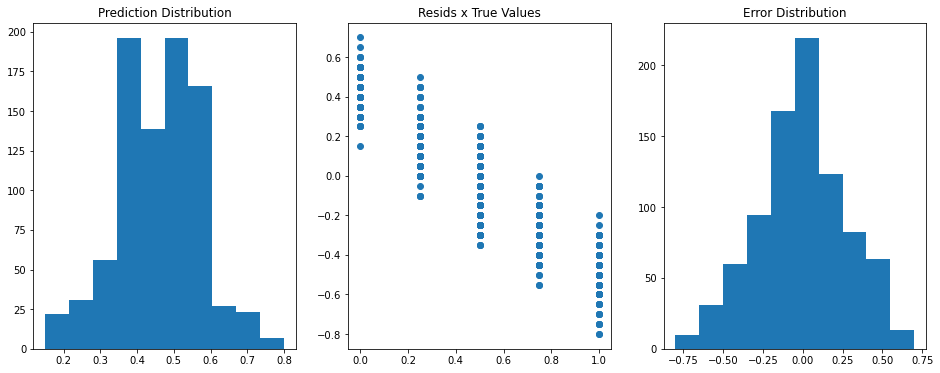

LassoCV() 

Training score: 0.2404 , Testing score: 0.2167 

Baseline: 2.9587 , Pred mean: 0.5483 , Pred variance: 0.0069


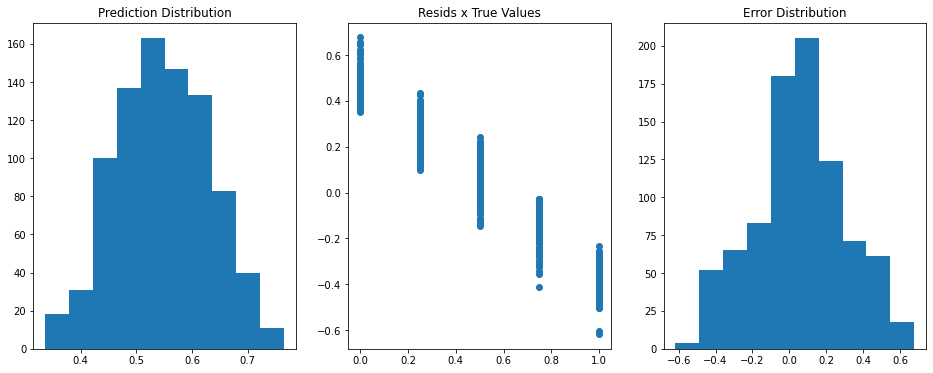

LinearRegression() 

Training score: 0.2463 , Testing score: 0.2103 

Baseline: 2.9587 , Pred mean: 0.6286 , Pred variance: 0.0073


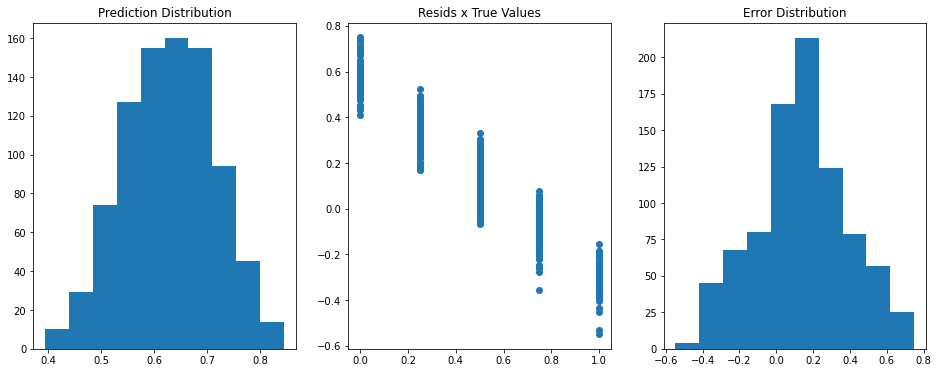

RandomForestRegressor() 

Training score: 0.885 , Testing score: 0.1874 

Baseline: 2.9587 , Pred mean: 0.4937 , Pred variance: 0.0242


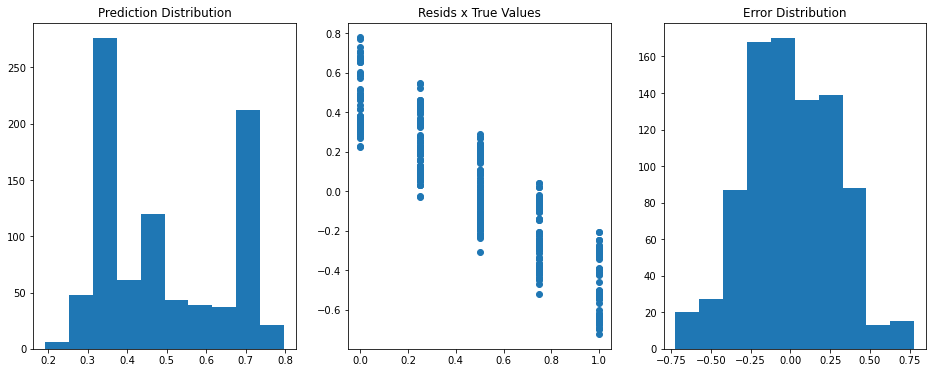

GradientBoostingRegressor() 

Training score: 0.3315 , Testing score: 0.2295 

Baseline: 2.9587 , Pred mean: 0.5018 , Pred variance: 0.0085


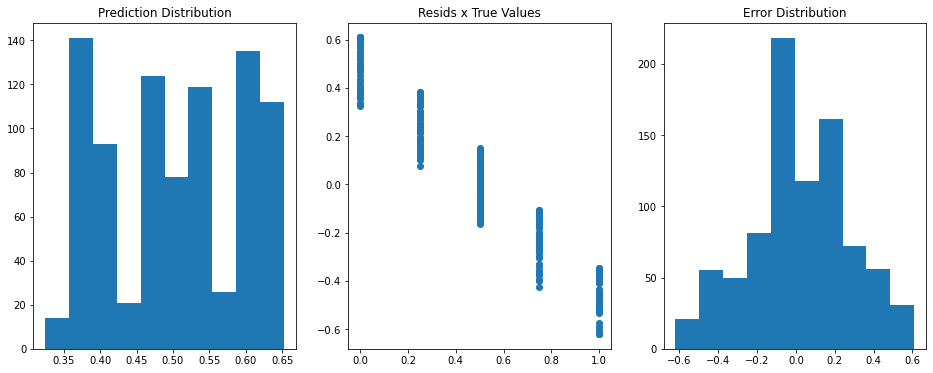

AdaBoostRegressor() 

Training score: 0.2031 , Testing score: 0.1786 

Baseline: 2.9587 , Pred mean: 0.4639 , Pred variance: 0.009


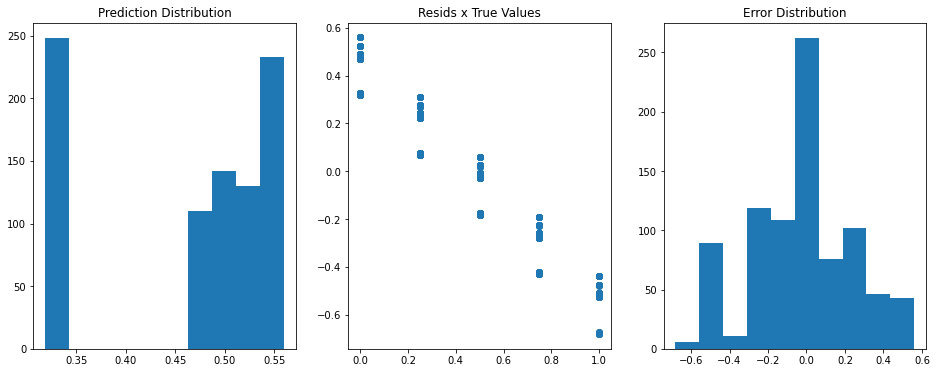

In [4]:
pred_list = []

for model in [KNeighborsRegressor(), LassoCV(), LinearRegression(), RandomForestRegressor(), \
              GradientBoostingRegressor(), AdaBoostRegressor()]:
    model.fit(X_train_sc, y_train)
    print(model, '\n\nTraining score:',round(model.score(X_train_sc,y_train),4),
          ', Testing score:', round(model.score(X_test_sc,y_test),4), '\n')
    preds = model.predict(X_test)
    pred_list.append(preds)
    resids = preds - y_test
    
    print('Baseline:',round(df.defund_support.mean(),4), ', Pred mean:', round(preds.mean(),4), \
          ', Pred variance:', round(np.var(preds),4))
    
    plt.figure(figsize = (16,6))
    
    pred = plt.subplot(1,3,1)
    res = plt.subplot(1,3,2)
    err = plt.subplot(1,3,3)
    
    pred.hist(preds)
    pred.set_title('Prediction Distribution')
    
    res.scatter(y_test, resids)
    res.set_title('Resids x True Values')
    
    err.hist(resids)
    err.set_title('Error Distribution')
    
    plt.show()

## Further experimentation
In this section, I define two functions to help extradite the experimentation process in terms of evaluating the success of a model and interpreting the meaning of the coefficients or feature importances. Then I utilize them to narrow down the list of features in an attempt to make my models more generalizable (with some success!).

In [5]:
def scores(model,X=X):
    X_tr = X.loc[X_train.index]
    X_te = X.loc[X_test.index]
    
    sc = StandardScaler()

    X_tr = sc.fit_transform(X_tr)
    X_te = sc.transform(X_te)
    
    
    model.fit(X_tr,y_train)
    train_score = model.score(X_tr,y_train)
    test_score = model.score(X_te,y_test)
    
    return print('Training score:',round(train_score,4),
                 ',  Testing score:',round(test_score,4),
                 '\nRMSE:', metrics.mean_squared_error(y_test,model.predict(X_te)) ** 0.5)


def get_feats(model, c_or_i, num_feats,X = X):
    if c_or_i == 'importance':
        coefs = model.feature_importances_
    else:
        coefs = model.coef_
        
    df = pd.DataFrame(abs(coefs), X.columns, columns = ['coefs'])
    df.sort_values('coefs', ascending = False, inplace = True)
    return df.index[:num_feats]

### Grid searched scores prior to feature selection

I removed the GridSearchCV code because it was too much for my computer to run multiple times, but I instantiate the models below with their `best_params_`. Using those grid searched parameters, I gathered the model scores to compare them to the hopefully more generalizable models with fewer features.

In [6]:
lr = LinearRegression()
las = LassoCV(random_state = 42)
ada = AdaBoostRegressor(base_estimator = GradientBoostingRegressor(),
                        learning_rate = 0.9, n_estimators = 40, random_state = 42)
gb = GradientBoostingRegressor(min_samples_split = 3, random_state = 42)

In [7]:
feat_list = []

for model,c_or_i,name in zip([lr,las,ada,gb],['coef','coef','importance','importance'],['LR','Lasso','Ada','GB']):
    model.fit(X_train_sc,y_train)
    feat_list.extend(get_feats(model,c_or_i,33))

### Grid searched scores after feature selection

Now I'm going to use that narrowed feature list in the same models to see if there is any improvement. I played around with various values for the number of features I extract from each model and settled on 33 (used above) as a good number. It's still a long list of features but this cutoff seemed to have the best outcomes!

In [8]:
# keeping track of the lists of features for all possible cutoffs to make my life easier later

lr = LinearRegression()
las = LassoCV(random_state = 42)
rf = RandomForestRegressor(max_depth = 5, min_samples_split = 4,
                           n_estimators = 200, random_state = 42)
gb = GradientBoostingRegressor(min_samples_split = 3, random_state = 42)

feat_dict = {}

for i in range(10,50):
    for model,c_or_i,name in zip([lr,las,rf,gb],['coef','coef','importance','importance'],['LR','Lasso','RF','GB']):
        model.fit(X_train_sc,y_train)
        feat_dict[i] = get_feats(model,c_or_i,i)

In [9]:
feats = set(feat_list)

X_narrow = df[feats]
X_train_narrow = X_narrow.loc[X_train.index]
X_test_narrow = X_narrow.loc[X_test.index]

sc = StandardScaler()

X_train_narrow_sc = sc.fit_transform(X_train_narrow)
X_test_narrow_sc = sc.transform(X_test_narrow)

In [10]:
lr = LinearRegression()
las = LassoCV(random_state = 42)
ada = AdaBoostRegressor(base_estimator = GradientBoostingRegressor(),
                        learning_rate = 0.9, n_estimators = 40, random_state = 42)
gb = GradientBoostingRegressor(min_samples_split = 3, random_state = 42)

test_scores = []

for model,name in zip([lr,las,ada,gb],['LR','Lasso','Ada','GB']):
    model.fit(X_train_narrow_sc,y_train)
    print('\n'+name)
    test_scores.append(model.score(X_test_narrow_sc,y_test))
    scores(model, X = X[feats])


LR
Training score: 0.2462 ,  Testing score: 0.211 
RMSE: 0.24406856662702991


/Users/elliotrichardson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02614947728764605, tolerance: 0.020849243933357485
  model = cd_fast.enet_coordinate_descent_gram(
/Users/elliotrichardson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.021298129554139678, tolerance: 0.02050881474103587
  model = cd_fast.enet_coordinate_descent_gram(
/Users/elliotrichardson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02614947728764605, tolerance: 0.020849243933357485
  model = cd_fast.enet_coordinate_descent_gram(



Lasso
Training score: 0.2414 ,  Testing score: 0.2175 
RMSE: 0.2430553810732822


/Users/elliotrichardson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.021298129554139678, tolerance: 0.02050881474103587
  model = cd_fast.enet_coordinate_descent_gram(



Ada
Training score: 0.3361 ,  Testing score: 0.2235 
RMSE: 0.24212473067568085

GB
Training score: 0.3296 ,  Testing score: 0.231 
RMSE: 0.24095693666559184


**Some success!** The models seem to be a bit more generalizable now that I've narrowed the features a bit. 

### Trying a voting regressor
I'd like to be able to ensemble these models if possible so I'm going to try throwing these into a VotingRegressor.

In [11]:
lr = LinearRegression()
las = LassoCV(random_state = 42)
ada = AdaBoostRegressor(base_estimator = GradientBoostingRegressor(),
                        learning_rate = 0.9, n_estimators = 40, random_state = 42)
gb = GradientBoostingRegressor(min_samples_split = 3, random_state = 42)

weights = [score/sum(test_scores) for score in test_scores]  # using scores from above to weight the models

vote = VotingRegressor([
    ('lr', lr),
    ('las',las),
    ('ada', ada),
    ('gb', gb)],
    weights = weights)

scores(vote, X = X[feat_dict[43]])

Training score: 0.2982 ,  Testing score: 0.2264 
RMSE: 0.24167741051998964


**Pretty good but not better than the Gradient Boost on its own.** Before I move on to my next experiment, I'm going to see how neural nets perform for this project.

### Trying neural nets

All feats 
Training score: 0.7909 , Testing score: -0.0796 , RMSE: 0.2855 

Narrowed 
Training score: 0.7531 , Testing score: -0.0892 , RMSE: 0.2868 



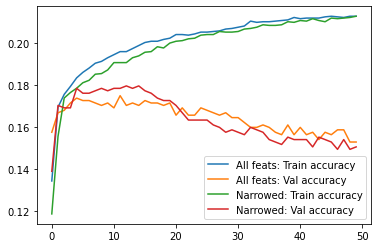

In [12]:
for name, X_tr, X_te in zip(['All feats','Narrowed'],[X_train_sc,X_train_narrow_sc],[X_test_sc,X_test_narrow_sc]):
    nn = Sequential()
    nn.add(Dense(128,
                    input_shape = (X_tr.shape[1],),
                    activation = 'relu'))
    nn.add(Dense(64,activation = 'relu'))
    nn.add(Dense(32,activation = 'relu'))
    nn.add(Dense(1, activation='sigmoid'))

    nn.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

    history = nn.fit(X_tr, y_train, validation_data=(X_te, y_test),
                     epochs=50, batch_size=512, verbose=0)
    
    train_score = round(metrics.r2_score(y_train,nn.predict(X_tr)),4)
    test_score = round(metrics.r2_score(y_test,nn.predict(X_te)),4)
    rmse = round(metrics.mean_squared_error(y_test,nn.predict(X_te)) ** 0.5,4)
    
    print(name,'\nTraining score:',train_score,', Testing score:',test_score, ', RMSE:',rmse,'\n')

    plt.plot(history.history['accuracy'], label=name+': Train accuracy')
    plt.plot(history.history['val_accuracy'], label=name+': Val accuracy')
    plt.legend();

**That uhhhh really didn't work.** Nevermind about the neural nets! 

### Finding unique feature sets for each type of model
Now I'm going to see if there are different cutoffs that work best for each of my four best models by looping through a ton of different possibilities and keeping track of the highest performing parameters.

In [13]:
best_combo = ('model',0)
best_score = 0

best_lr_combo = 0
best_lr_score = 0

best_las_combo = 0
best_las_score = 0

best_ada_combo = 0
best_ada_score = 0

best_gb_combo = 0
best_gb_score = 0

lr = LinearRegression()
las = LassoCV(random_state = 42)
ada = AdaBoostRegressor(base_estimator = GradientBoostingRegressor(),
                        learning_rate = 0.9, n_estimators = 40, random_state = 42)
gb = GradientBoostingRegressor(min_samples_split = 3, random_state = 42)


In [14]:
for model,c_or_i,name in zip([lr,las,ada,gb],['coef','coef','importance','importance'],['LR','Lasso','Ada','GB']):
    for i in range(10,50):
        feat_list = feat_dict[i]
        X_tr = X[feat_list].loc[X_train.index]
        X_te = X[feat_list].loc[X_test.index]

        sc = StandardScaler()

        X_tr = sc.fit_transform(X_tr)
        X_te = sc.transform(X_te)
        
        model.fit(X_tr,y_train)
        score = model.score(X_te,y_test)
        if score > best_score:
            best_score = score
            best_combo = (name,i)
            
        if name == 'LR' and score > best_lr_score:
            best_lr_score = score
            best_lr_combo = i

        elif name == 'Lasso' and score > best_las_score:
            best_las_score = score
            best_las_combo = i

        elif name == 'Ada' and score > best_ada_score:
            best_ada_score = score
            best_ada_combo = i

        elif name == 'GB' and score > best_gb_score:
            best_gb_score = score
            best_gb_combo = i
            
print('Best LR score:', best_lr_score, ', Best LR combo:', best_lr_combo,'\n')
print('Best Lasso score:', best_las_score, ', Best Lasso combo:', best_las_combo,'\n')
print('Best Ada score:', best_ada_score, ', Best Ada combo:', best_ada_combo,'\n')
print('Best GB score:', best_gb_score, ', Best GB combo:', best_gb_combo,'\n')
print('\nBest score:', best_score, ', Best combo:', best_combo)

Best LR score: 0.21963383864880892 , Best LR combo: 31 

Best Lasso score: 0.21971217974268686 , Best Lasso combo: 30 

Best Ada score: 0.2241255096510546 , Best Ada combo: 37 

Best GB score: 0.23258213590264054 , Best GB combo: 31 


Best score: 0.23258213590264054 , Best combo: ('GB', 31)


**Best score yet!** That helped the individual scores a bit and the gradient boost with 31 features got the best score so far, but I'd love to ensemble the models if possible. Since I can't use different features for each model in a voting ensemble, I'm going to make my own. 

### Manual voting regressor model

Below, I use the test scores from above to weight the models, create predictions using the best cutoff for each model, and then calculate a weighted average for each prediction.

In [15]:
lr = LinearRegression()
las = LassoCV(random_state = 42)
ada = AdaBoostRegressor(base_estimator = GradientBoostingRegressor(),
                        learning_rate = 0.9, n_estimators = 40, random_state = 42)
gb = GradientBoostingRegressor(min_samples_split = 3, random_state = 42)

test_scores = [best_lr_score,best_las_score,best_ada_score,best_gb_score]
weights = [score/sum(test_scores) for score in test_scores]

pred_df = pd.DataFrame()

for model, name, weight, n in zip([lr,las,ada,gb],['LR','Lasso','Ada','GB'],weights,                             
    [best_lr_combo,best_las_combo,best_ada_combo,best_gb_combo]):
    
    feats = feat_dict[n]
    X_tr = X[feat_list].loc[X_train.index]
    X_te = X[feat_list].loc[X_test.index]

    sc = StandardScaler()
    X_tr = sc.fit_transform(X_tr)
    X_te = sc.transform(X_te)
    
    model.fit(X_tr,y_train)
    preds = model.predict(X_te)
    preds * weight
    
    pred_df[name] = list(preds * weight)

pred_df['pred'] = sum([pred_df['LR'],pred_df['Lasso'],pred_df['Ada'],pred_df['GB']])

print('Testing score:',metrics.r2_score(y_test, list(pred_df['pred'])))

Testing score: 0.22751493125351918


**Pretty good!** That's a relatively good score, but not better than the GB model on its own.

## Final model selection

The above experimentations failed to outperform the GradientBoostingRegressor model on it's own with 31 features. I recreated the model and found the most important features below.

In [16]:
gb = GradientBoostingRegressor(min_samples_split = 3, random_state = 42)
scores(gb,X = X[feat_dict[best_gb_combo]])
gb_top_feats = get_feats(gb, 'importance', num_feats = 10, X = X[feat_dict[best_gb_combo]])
print('\n~~~~~~~ Top Ten Features ~~~~~~~\n')

coef_dict = {X[feat_dict[best_gb_combo]].columns[i]: gb.feature_importances_[i] for i in range(best_gb_combo)}

for feat in gb_top_feats:
    spaces = ' '*(25-len(feat))
    print(feat,spaces, round(coef_dict[feat],4))

Training score: 0.3268 ,  Testing score: 0.2326 
RMSE: 0.24070672991687062

~~~~~~~ Top Ten Features ~~~~~~~

political_party_gop        0.274
age_group                  0.1076
political_party_dem        0.1005
education_level            0.0582
income_bracket             0.0436
religion_atheist           0.0426
religion_protestant        0.041
religion_agnostic          0.038
relig_activity             0.0333
religion_catholic          0.0266
